*This notebook was created by Mykola Veremchuk (mykola.veremchuk@xfel.eu), Svitozar Serkez. Source and license info is on [GitHub](https://github.com/ocelot-collab/ocelot). July 2019.*

## PFS tutorial N3. Reflection from imperfect highly polished mirror.

In this tutorial we will illustrate generation of imperfect surface and reflection of the radiation fields from it

In [1]:
from ocelot.optics.wave import * 
from ocelot.gui.dfl_plot import *

# setup logger level (it is not necessary)
from ocelot.optics.wave import _logger
import logging
_logger.setLevel(logging.ERROR)

from ocelot.gui.dfl_plot import _logger
_logger.setLevel(logging.ERROR)

initializing ocelot...


In [2]:
# Activate interactive matplolib in notebook
import matplotlib
%matplotlib inline
# Setup figure white background 
matplotlib.rcParams["figure.facecolor"] = (1,1,1,1)
# Setup figure size
matplotlib.rcParams['figure.figsize'] = [10, 10]


### Contents
1. [Generating highly polished mirror](#mirror)
2. [Reflection of radiation field from imperfect mirror](#reflect) 

<a id='mirror'></a>
## Highly polished mirror 
Generation of mirror surfaces is based on
[W.Q. Hua, F.G. Bian, Y.M. He, W.H. Lin, L. Song, J. Wang, N. Zhao, 
Using the power spectral density method to characterize and evaluate the X-ray mirrors surfaces (2013)](https://accelconf.web.cern.ch/accelconf/IPAC2013/papers/wepwa030.pdf)

We model mirror with 1D surface as the angle of incidence with respect to the surface is quite small in X-ray reflective optics.

The height errors along the axis

\begin{equation}
h^\prime (x) = \frac{M}{L} F^{-1} \Big( \sqrt{L \cdot PSD(k)}  e^{j\phi(k)} \Big)
\end{equation}

where

* $PSD(k)$ : power spectral density of the surface 
* $M$ : number of points (pixels) on the surface
* $L$ : length of the surface
* $\phi(k)$ : randomly valued phase map ($-\pi < \phi(k) < \pi$)
* $k$ : wavevector

Reflection function is based on
[S. Serkez Design and Optimization of the Grating Monochromator for Soft X-Ray Self-Seeding FELs](https://www.researchgate.net/publication/311516090_Design_and_Optimization_of_the_Grating_Monochromator_for_Soft_X-Ray_Self-Seeding_FELs)

PSD can be calculated using

\begin{equation}
PSD(k) = \frac{1}{L}  \int_{-L/2}^{L/2} h(x) e^{-j2\pi kx} dx
\end{equation}

PSD of a highly polished mirror typically yields a line in a loglog scale:

\begin{equation}
PSD(k) = b * k - \alpha
\end{equation}

where
* $b$ is the slope of the power spectrum on a log-log scale 
* $\alpha$ is determined by the fractal dimension D satisfying 1 < D < 2, D = (5 - $\alpha$) / 2


To generate HeightProfile with ocelot one can use the function:

```hprofile = generate_1d_profile(hrms, length=0.1, points_number=1000)```

* ```hrms```: [m] height errors root mean square
* ```length```: [m] length of the surface
* ```points_number```: number of points of the surface

Optional parameters:

* ```wavevector_cutoff```: [1/m] spacial frequency below which PSD(k) reaches plateou, default is 0
* ```psd```: [m^3] 1d array; power spectral density of surface (if not specified, will be generated) (if specified, must have shape = (points_number // 2 + 1, ), otherwise it will be cut to appropriate shape)
* ```seed```: seed for np.random.seed() to allow reproducibility

The function returns ocelot.optics.HeightProfile object, which can describe a geometry of not only the mirror surface 

In [3]:
hprofile1 = generate_1d_profile(hrms=1e-9, length=0.03, points_number=1000, seed=666)


One can plot HeightProfile using function
```plot_1d_hprofile()```


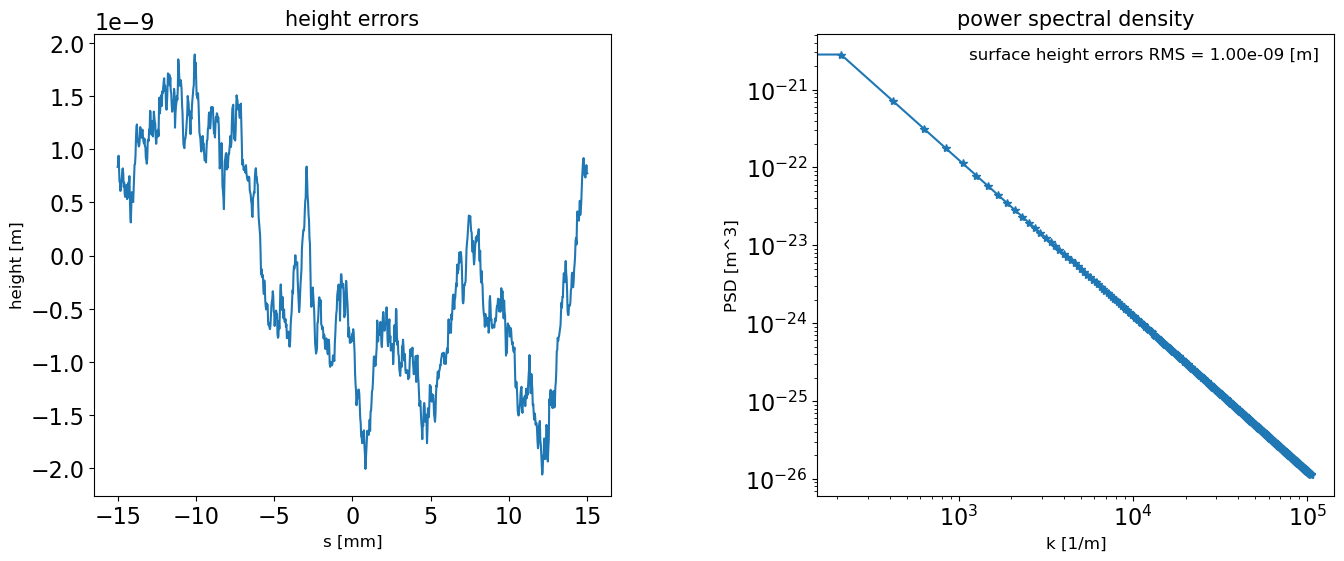

In [4]:
plot_1d_hprofile(hprofile1, fig_name='mirror1 height profile and PSD')


In [5]:
#HeightProfile with ```wavevector_cutoff = 10^3```
hprofile2 = generate_1d_profile(hrms=1e-9, length=0.1, points_number=5000, wavevector_cutoff=1e3)

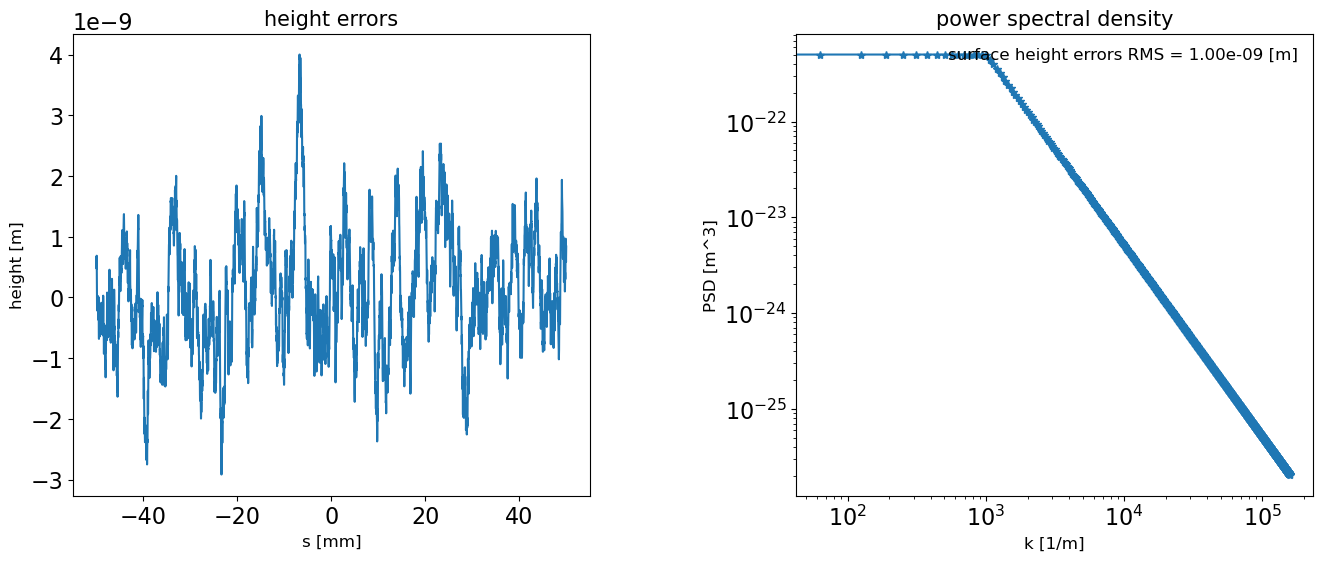

In [6]:
plot_1d_hprofile(hprofile2, fig_name='mirror2 height profile and PSD')

<a id='reflect'></a>
## Reflection radiation field from imperfect mirror 

Reflection function implementation is discussed in [S. Serkez, Design and Optimization of the Grating Monochromator for Soft X-Ray Self-Seeding FELs (2015), page 42-44](https://www.researchgate.net/publication/311516090_Design_and_Optimization_of_the_Grating_Monochromator_for_Soft_X-Ray_Self-Seeding_FELs) (see references therein).

A height error $\delta h$ on the optical surface will perturb the phase of a reflected wavefront $\delta \phi$

\begin{equation}
\delta \phi = \frac{4 \pi \delta h}{\lambda} \sin \theta_i
\end{equation}

where
* $\theta_i$ : the radiation angle of incidence with respect to the mirror surface
* $\lambda$ : the radiation wavelength

To reflect radiation field (ocelot.optics.wave.RadiationField) off the mirror with height (ocelot.optics.wave.HeightProfile) there is the function:

```dfl_reflect_surface(dfl, angle, height_profile=None, axis='x')```

* ```dfl```: RadiationField object from ocelot.optics.wave
* ```angle```: [rad] angle of incidence with respect to the surface
* ```height_profile```: HeightProfile object of the reflecting surface (if not specified, will be generated using ```hrms```)
* ```axis```: direction along which reflection takes place

Optional parameters:

* ```hrms```: [m] height root mean square of reflecting surface (if ```height_profile``` is not specified, ```hrms``` will be used to generate height_profile internally)
* ```seed```: seed for np.random.seed() to allow reproducibility
* ```return_height_profile```: boolean type variable; if True, the function will return height_profile which was used for reflection


In [7]:
# generating gaussian RadiationField
dfl1 = generate_gaussian_dfl(1e-9, (1000, 1000, 1))

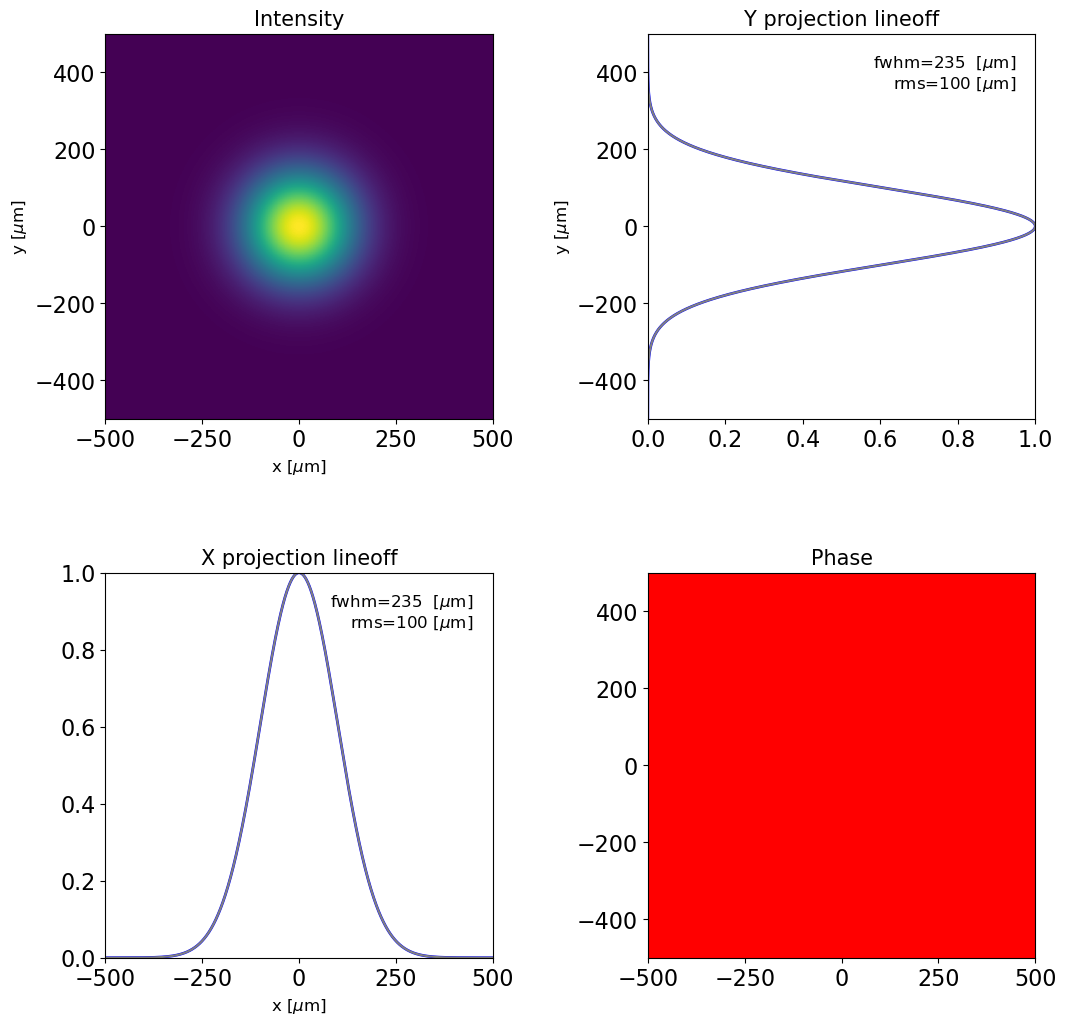

In [8]:
#radiation ritght before mirror1
plot_dfl(dfl1, phase=1, fig_name='radiation before the mirror1')

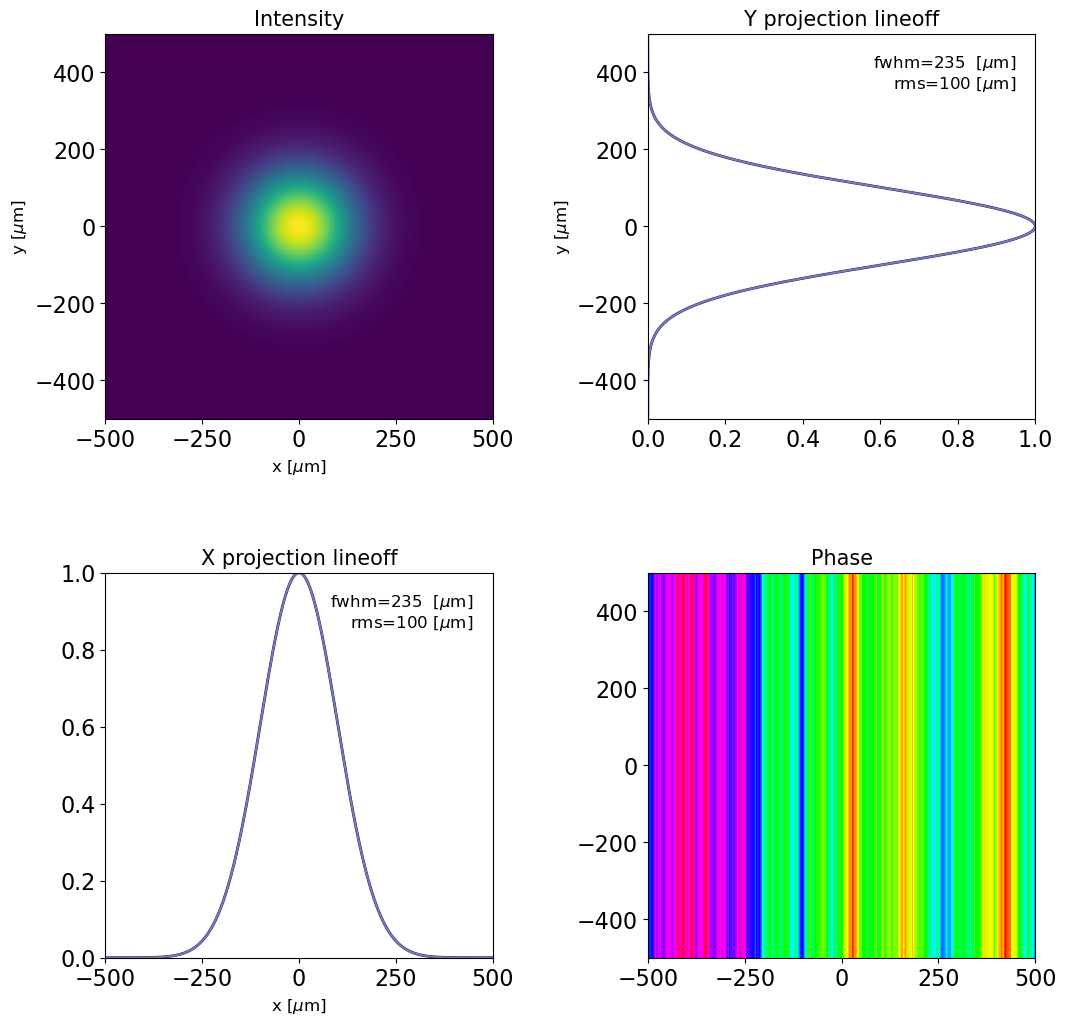

In [9]:
# reflecting RadiationField from mirror1 and plotting the result
dfl_reflect_surface(dfl1, angle=np.pi * 2 / 180, height_profile=hprofile1, axis='x')
plot_dfl(dfl1, phase=1, fig_name='radiation after reflection from mirror1')

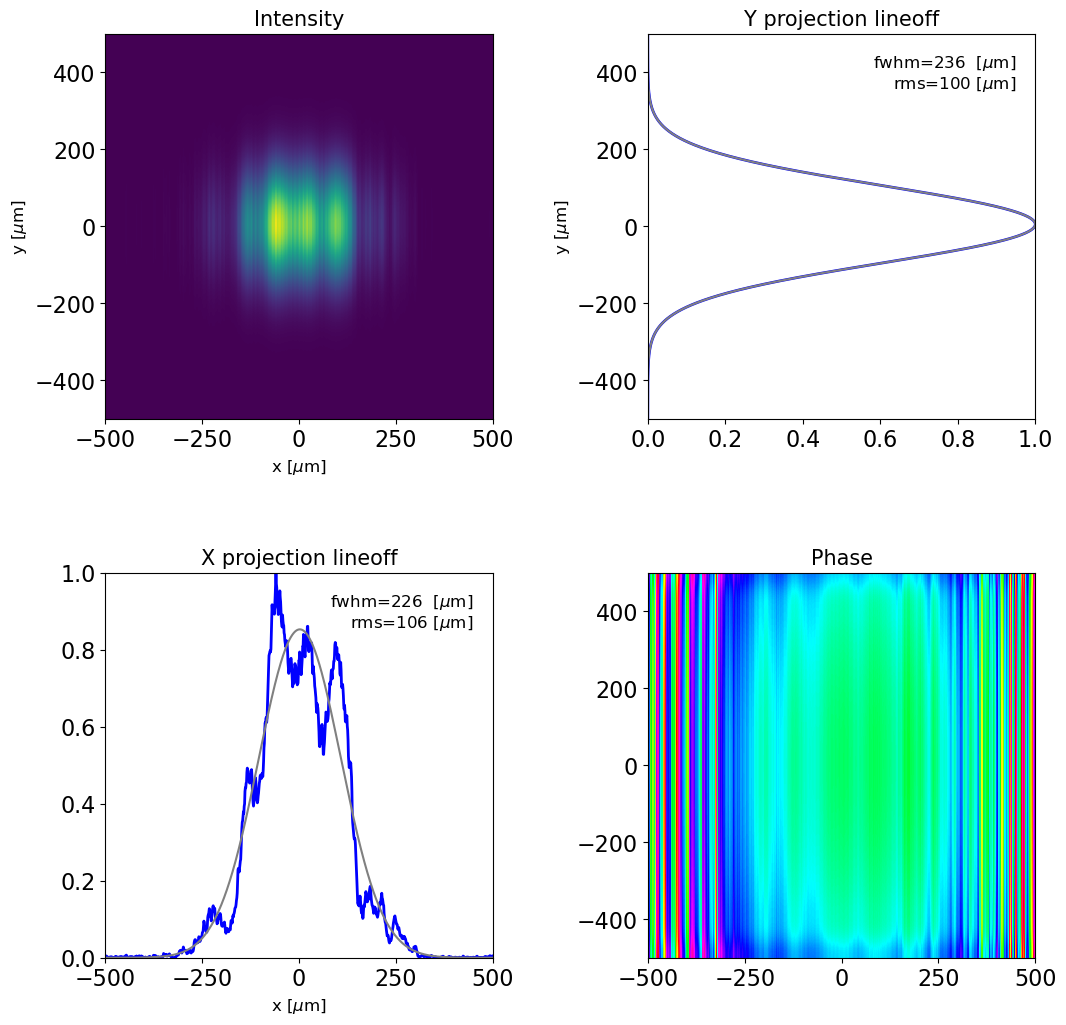

In [10]:
# propagating RadiationField after reflection for 10 meters and plotting the result
dfl1.prop(z=10)
plot_dfl(dfl1, phase=1, fig_name='radiation after reflection from mirror1 and propagation')

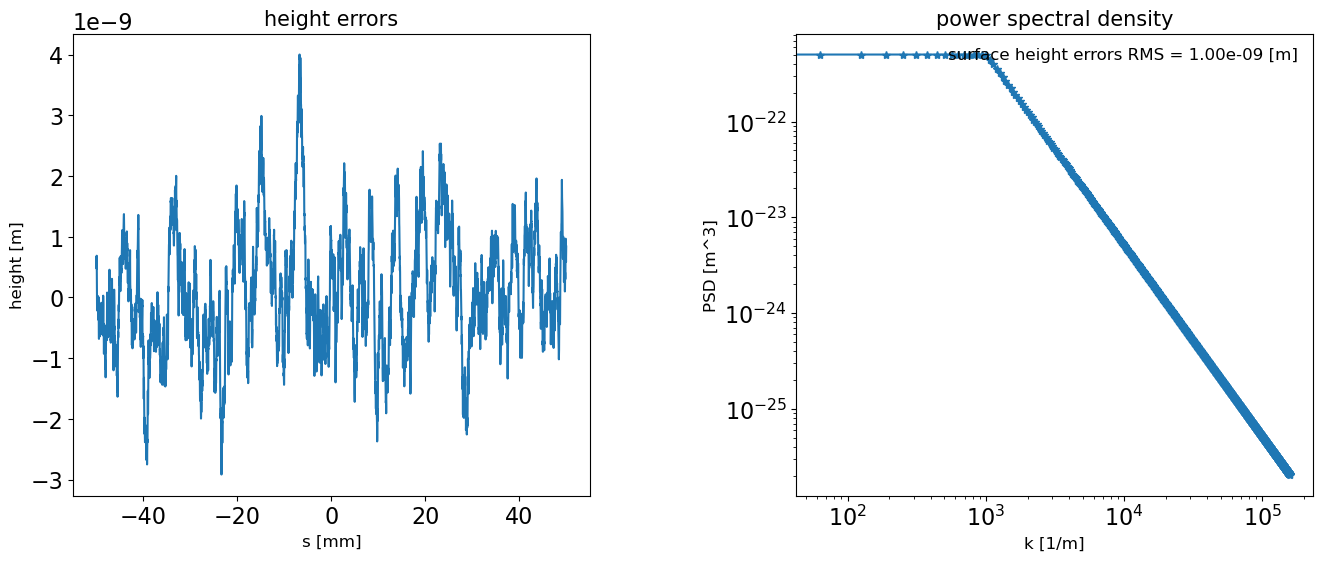

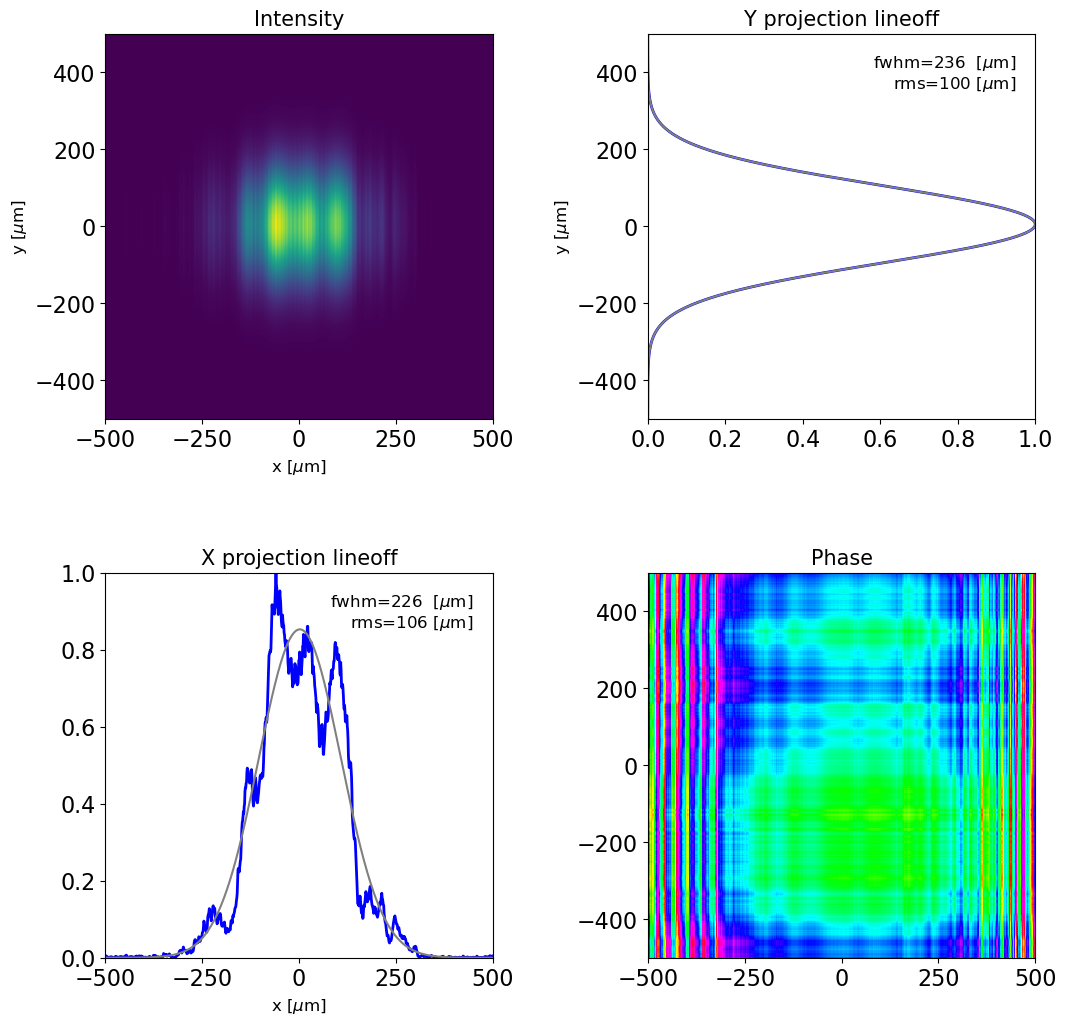

In [11]:
# reflecting RadiationField from another imperfect mirror vertically (also ```height_profile``` is not specified, so it will be generated internally)
hprofile3 = dfl_reflect_surface(dfl1, angle=np.pi * 2 / 180, hrms=1e-9, axis='y', return_height_profile=1, seed=13)
plot_1d_hprofile(hprofile2, fig_name='internally generated mirror3 height profile and PSD') 
plot_dfl(dfl1, phase=1, fig_name='radiation after reflection from mirror3')

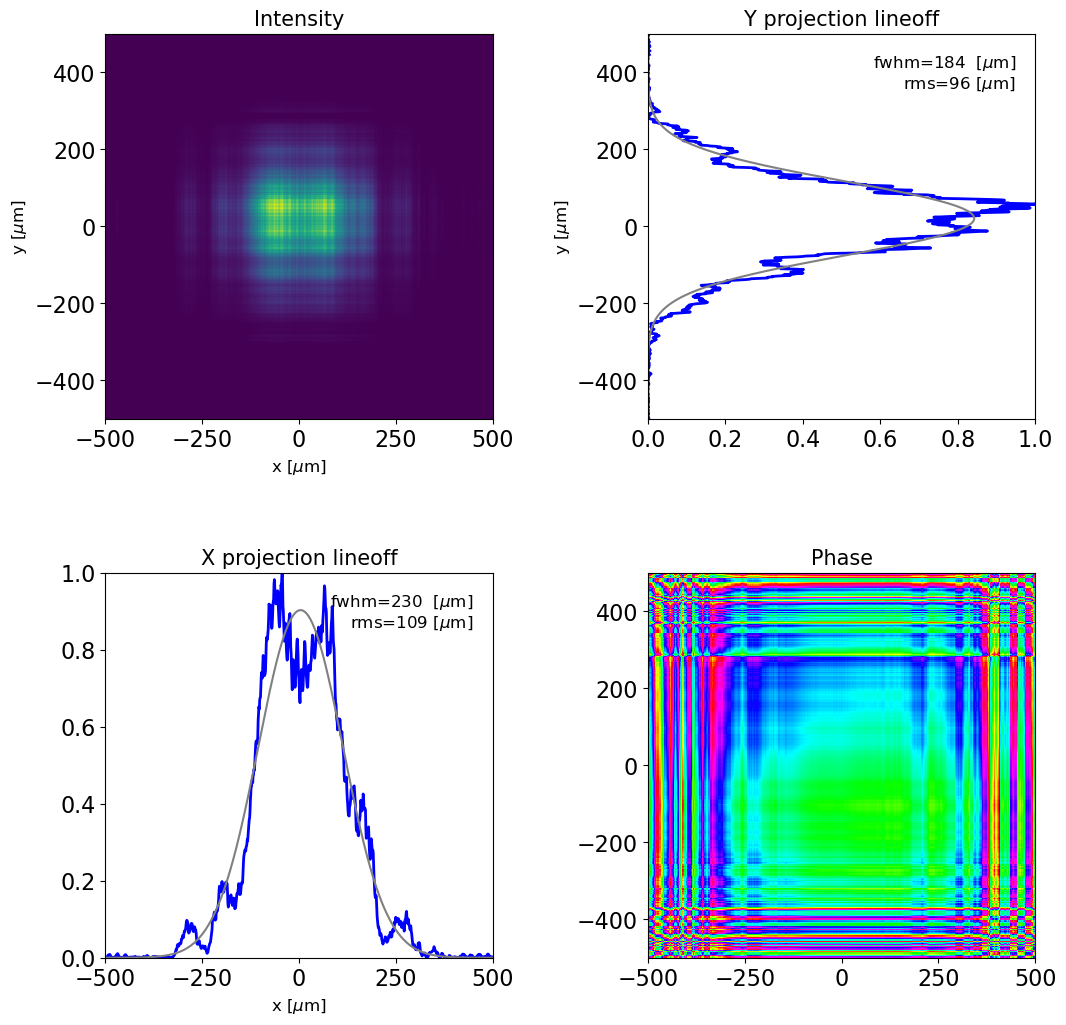

In [12]:
# propagating RadiationField for another 10 meters and plotting the result
dfl1.prop(z=10)
plot_dfl(dfl1, phase=1, fig_name='result of reflection from two rough mirrors')